In [2]:
import numpy as np
import matplotlib.pyplot as plt
import probfit
import iminuit
import math
from statnight.utils.wrappers import ModelWrapper, LossFunctionWrapper, MinimizerWrapper
from statnight.parameters import Space, Variable, Constant, POI
from statnight.utils.stats import integrate1d
from statnight.hypothesis import Hypothesis
from statnight.hypotest import Discovery
from statnight.calculators import AsymptoticCalculator
from statnight.config import Config

## Signal + background fit:

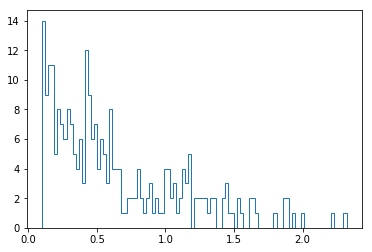

In [3]:
bounds = (0.1, 3.0)

# Data and signal

np.random.seed(0)
tau = -2.0
beta = -1/tau
data = np.random.exponential(beta, 300)
peak = np.random.normal(1.2, 0.1, 20)
data = np.concatenate((data,peak))
data = data[(data > bounds[0]) & (data < bounds[1])]

plt.hist(data, bins=100, histtype='step');

In [4]:
bkg_pdf = probfit.Normalized(probfit.exponential, bounds)
sig_pdf = probfit.Normalized(probfit.gaussian, bounds)
bkg_pdf_ext = probfit.Extended(bkg_pdf, "Nbkg")
sig_pdf_ext = probfit.Extended(sig_pdf, "Nsig")
tot_pdf = probfit.AddPdf(bkg_pdf_ext, sig_pdf_ext)

In [6]:
tot_model = ModelWrapper(tot_pdf)

tot_model.add_obs(Space("x", range = bounds))

mean  = Constant("mean",  value=1.2)
sigma = Constant("sigma", value= 0.1)
Nsig  = Variable("Nsig",  range=(-10,len((data))),   initvalue= 20.0,       initstep=1.0, isyield=True)
tau   = Variable("lambda",   range=(0.1, 5.0), initvalue=2.0, initstep=0.05)
Nbkg  = Variable("Nbkg",  range=(0,len((data))*1.1), initvalue= len(data), initstep=1.0, isyield=True)

tot_model.add_vars(mean, sigma, Nsig, tau, Nbkg)

tot_model.extended = True

In [7]:
LH = LossFunctionWrapper(probfit.UnbinnedLH(tot_model, data, extended=True, extended_bound=bounds))

In [8]:
minimizer = MinimizerWrapper(LH)

In [9]:
minimizer.minimize();

FCN = -1122.2746893892593 
 TOTAL NCALL = 57 
 NCALLS = 57 
 
 
 EDM = 2.5646052488015777e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,lambda,1.93498,0.140514,,,0.1,5,No
1,Nbkg,251.377,16.6897,,,0,292.6,No
2,mean,1.2,1,,,,,Yes
3,sigma,0.1,1,,,,,Yes
4,Nsig,14.6157,6.66259,,,-10,266,No


In [10]:
def plotfitresult(pdf, bounds, nbins, *args):
    x = np.linspace(bounds[0], bounds[1], nbins)
    bin_centers = x[:-1] + np.diff(x)/2.
    y = np.zeros(bin_centers.shape)
    
    for i in range(nbins-1):
        y[i] = integrate1d(pdf, (x[i],x[i+1]), 100, *args)
        
    plt.plot(bin_centers, y, "-r")      

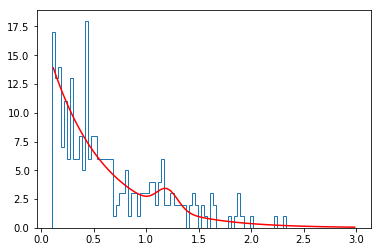

In [11]:
nbins = 100
fit_result = minimizer.values.values()
plt.hist(data, bins=nbins, histtype='step', range=bounds);
plotfitresult(tot_model, bounds, nbins, *fit_result)

/Users/matthieumarinangeli/anaconda3/envs/tfn/lib/python3.6/site-packages/iminuit/_minuit_methods.py:88: RuntimeWarning: band and text is requested but the bound is too narrow.
  warn(RuntimeWarning('band and text is requested but '


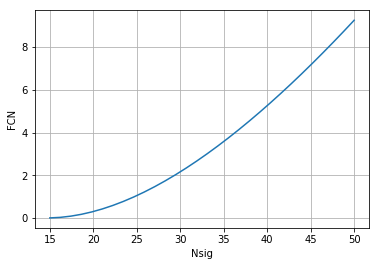

In [12]:
minimizer._minuit.draw_mnprofile("Nsig", bound=(15, 50),  bins=30, subtract_min=True);

In [ ]:
def pll(self, param, value):
    range = (value, -1.)
    prof = minimizer._minuit.mnprofile(param, 1, range)
    if prof[1] > 0:
       print("WARNING! Large positive value for EDM for ", value)
    return prof[1]

## Discovery significance.

In [13]:
def lossbuilder(model, data, weights=None):
    model = model[0]
    data = data[0]
    weights = weights[0]
    loss = LossFunctionWrapper(probfit.UnbinnedLH(model, data, extended=True, extended_bound=bounds, weights=weights))
    return loss
    
config = Config(tot_model, data, lossbuilder, MinimizerWrapper)
config.bestfit = minimizer.values

TypeError: __init__() missing 1 required positional argument: 'pll'

In [ ]:
calc = AsymptoticCalculator(config)

In [ ]:
poinull = POI("Nsig", value=0)
discovery_test = Discovery(poinull, calc)

In [ ]:
discovery_test.result();

In [ ]:
calc.qobs(poinull, POI("Nsig", value=34.9626))